In [17]:
import sys
import os
import torch
import transformers
import json
from transformers import LlamaTokenizer, LlamaForCausalLM, GenerationConfig
from src.model.minigpt4 import MiniGPT4
from tqdm import *
import random
from generation import *
import json
device = "cuda:4" if torch.cuda.is_available() else "cpu"
model = MiniGPT4(lora_r=64)
model = model.to(device)
model.load_state_dict(torch.load("/data1/poong/PosterNUWA/log_dir/train_stage2/checkpoints/checkpoint-1/pytorch_model.bin",map_location="cpu"))
model.device = device
#model.half()
model.eval()
def evaluate(
    image,
    html_input,
    temperature=0.6,
    top_p=0.9,
    top_k=40,
    num_beams=4,
    do_sample=True,
    max_new_tokens=1024,
    **kwargs,
):

    # import pdb; pdb.set_trace()
    with torch.no_grad():
        with torch.autocast(device_type="cuda"):
            generation_output = model.generate(image,html_input,max_new_tokens=max_new_tokens)
    return generation_output

file_path = "/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/html_format_test/test_numerical.jsonl"
with open(file_path, "r") as f:
    content = [json.loads(line) for line in f]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

/data1/poong/.conda/envs/jaepoong/lib/python3.9/site-packages/peft/utils/other.py:136: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035
Do not use Q-Former here.
Load 1 training prompts
Prompt Example 
['[INST] <Img><ImageHere></Img> [/INST] ']


In [74]:
from PIL import Image
from src.processor.blip_processors import Blip2ImageTrainProcessor
from html_to_ui import *
image_processor = Blip2ImageTrainProcessor()
def split_string_by_delimiter(input_string, delimiter):
    # 입력 문자열을 특정 문자(delimiter)를 기준으로 분할하여 전후 문자열을 반환합니다.
    parts = input_string.split(delimiter)

    # 분할된 문자열이 두 개 이상인 경우, 전후 문자열을 반환합니다.
    if len(parts) >= 2:
        before_delimiter = parts[0]
        after_delimiter = delimiter.join(parts[1:])
        return before_delimiter, after_delimiter
    else:
        # 특정 문자(delimiter)를 찾을 수 없는 경우, 원래 문자열과 빈 문자열을 반환합니다.
        return input_string, ""

img_path = "/data1/poong/PosterNUWA/data/cgl_dataset/layout_imgs_6w"
sample = content[10]
image = Image.open(os.path.join("data/cgl_dataset/box_inpainintg_layout_cgl",sample['name'][0][:-4]+"_mask000.png"))
image2 = image.copy()
img = image_processor(image).unsqueeze(0)
cond_recover_mask_input = sample.get("cond_recover_mask_input_seqs")
instruct_3,answer_3 = split_string_by_delimiter(cond_recover_mask_input[0],"<MID>")
cond_recover_mask = evaluate(img,[instruct_3])
cond_recover_mask

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['<body> <svg width="513" height="750"> <rect data-category="logo", x="146", y="26", width="222", height="42"/>\n<rect data-category="text", x="106", y="91", width="302", height="36"/>\n<rect data-category="text", x="113", y="138", width="288", height="41"/>\n<rect data-category="background", x="123", y="192", width="267", height="45"/>\n<rect data-category="text", x="140", y="200", width="235", height="23"/>\n<rect data-category="text", x="12", y="670", width="128", height="23"/> </svg> </body>']

<body> <svg width="513" height="750"> <rect data-category="logo", x="146", y="26", width="222", height="42"/>
<rect data-category="text", x="106", y="91", width="302", height="36"/>
<rect data-category="text", x="113", y="138", width="288", height="41"/>
<rect data-category="background", x="123", y="192", width="267", height="45"/>
<rect data-category="text", x="140", y="200", width="235", height="23"/>
<rect data-category="text", x="12", y="670", width="128", height="23"/> </svg> </body>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=513x750 at 0x7F80ED699880>
b, l :  [146, 26, 222, 42] 1
b, l :  [106, 91, 302, 36] 2
b, l :  [113, 138, 288, 41] 2
b, l :  [123, 192, 267, 45] 3
b, l :  [140, 200, 235, 23] 2
b, l :  [12, 670, 128, 23] 2


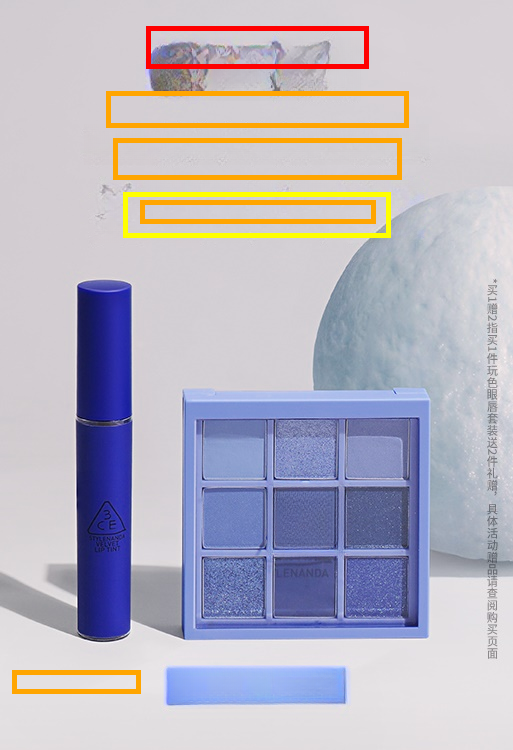

In [76]:
print(cond_recover_mask[0])
ex_bbox,ex_labels = get_bbox(cond_recover_mask[0])
draw_bbox(image,ex_bbox,ex_labels)


<PIL.Image.Image image mode=RGB size=513x750 at 0x7F80EC615FA0>
b, l :  [146, 37, 215, 64] 1
b, l :  [84, 124, 345, 41] 2
b, l :  [90, 178, 333, 65] 2
b, l :  [267, 482, 83, 78] 1
b, l :  [165, 666, 185, 43] 3
b, l :  [187, 677, 151, 23] 2


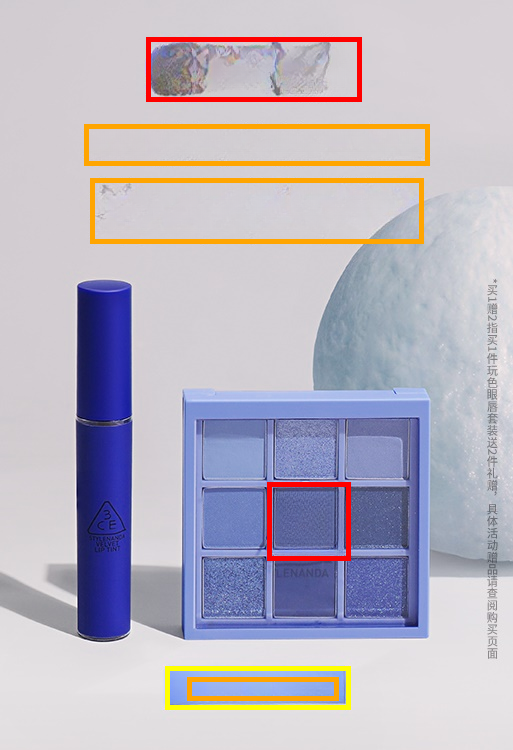

In [77]:
print(answer_3.strip())
ex_bbox,ex_labels = get_bbox(sample['labels'][0])
draw_bbox(image2,ex_bbox,ex_labels)

In [66]:
import json
file_path = "/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/html_format_test/test_numerical.jsonl"
with open(file_path, "r") as f:
    content = [json.loads(line) for line in f]

from PIL import Image
from src.processor.blip_processors import Blip2ImageTrainProcessor
from html_to_ui import *
image_processor = Blip2ImageTrainProcessor()
def split_string_by_delimiter(input_string, delimiter):
    # 입력 문자열을 특정 문자(delimiter)를 기준으로 분할하여 전후 문자열을 반환합니다.
    parts = input_string.split(delimiter)

    # 분할된 문자열이 두 개 이상인 경우, 전후 문자열을 반환합니다.
    if len(parts) >= 2:
        before_delimiter = parts[0]
        after_delimiter = delimiter.join(parts[1:])
        return before_delimiter, after_delimiter
    else:
        # 특정 문자(delimiter)를 찾을 수 없는 경우, 원래 문자열과 빈 문자열을 반환합니다.
        return input_string, ""

img_path = "/data1/poong/PosterNUWA/data/cgl_dataset/layout_imgs_6w"
samples = content[17]
image = Image.open(os.path.join("data/cgl_dataset/box_inpainintg_layout_cgl",samples['name'][0][:-4]+"_mask000.png"))
image2 = image.copy()
img = image_processor(image)
img_l = torch.stack([img]*3)

cond_cate_to_size_pos = samples.get("cond_cate_size_to_pos_input_seqs")
cond_cate_size_to_pos = samples.get("cond_cate_to_size_pos_input_seqs")
cond_recover_mask_input = samples.get("cond_recover_mask_input_seqs")
labels = samples.get("labels")
instruct = []
instruct_1,answer_3 = split_string_by_delimiter(cond_cate_to_size_pos[0],"<MID>")
instruct.append(instruct_1)
instruct_2,answer_3 = split_string_by_delimiter(cond_cate_size_to_pos[0],"<MID>")
instruct.append(instruct_2)
instruct_3,answer_3 = split_string_by_delimiter(cond_recover_mask_input[0],"<MID>")
instruct.append(instruct_3)

#instruct_3,answer_3 = split_string_by_delimiter(cond_recover_mask_input[0],"<MID>")
#cond_recover_mask = evaluate(img_l,instruct)
#cond_recover_mask


<PIL.Image.Image image mode=RGB size=513x750 at 0x7FC9D1938D60>
b, l :  [101, 28, 312, 44] 1
b, l :  [74, 107, 363, 45] 2
b, l :  [122, 159, 273, 40] 2
b, l :  [83, 459, 43, 41] 3
b, l :  [91, 467, 27, 24] 2


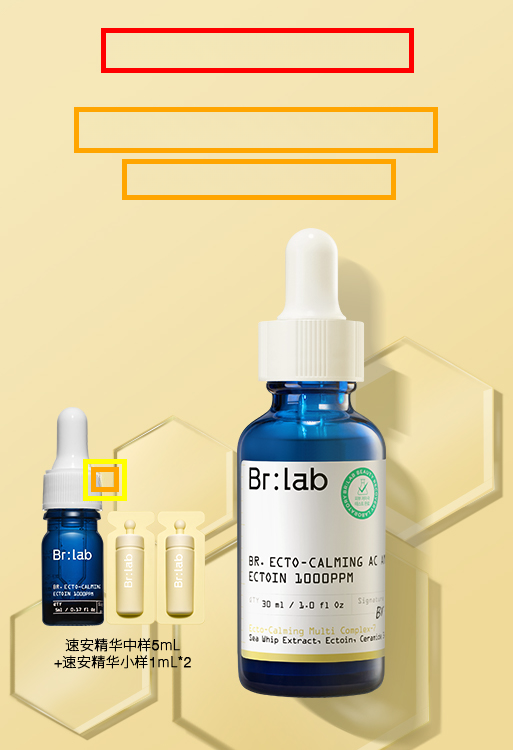

In [67]:
print(answer_3.strip())
image2 = image.copy()
ex_bbox,ex_labels = get_bbox(labels[0])
draw_bbox(image2,ex_bbox,ex_labels)

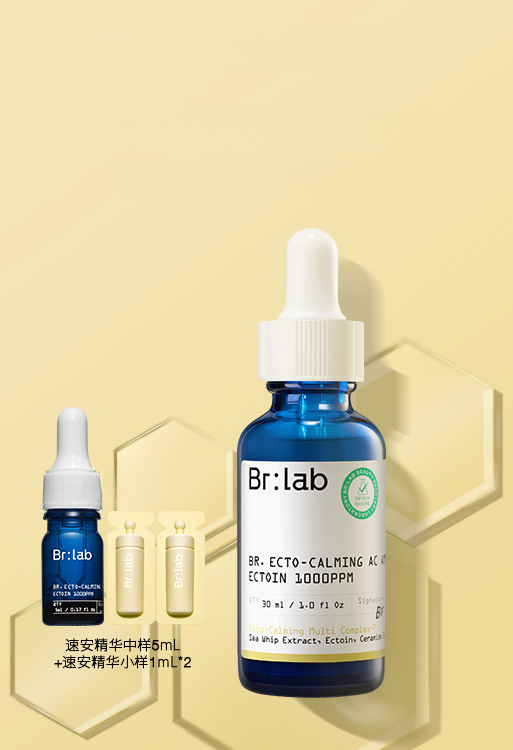

In [68]:
image

In [8]:
file_path="/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/html_format_test/test_numerical.jsonl"
output_dir = "/data1/poong/PosterNUWA/log_dir/test/generated_sample"
output_file = os.path.join(output_dir, file_path.split("/")[-1])
with open(output_file, "w") as f:
    for line in res:
        f.write(json.dumps(line) + "\n")

# ControllNet

In [77]:
# pip install accelerate transformers safetensors diffusers

import torch
import numpy as np
from PIL import Image
import json
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import DPTImageProcessor, DPTForDepthEstimation,DPTFeatureExtractor

import torch
from typing import List
from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore

from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline, AutoencoderKL
from diffusers.utils import load_image

from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore
import os
import copy


def concatenate_images(images: List[Image.Image]) -> Image.Image:
    # 이미지 크기 가져오기
    widths, heights = zip(*(img.size for img in images))

    # 총 가로 너비 계산
    total_width = sum(widths)

    # 새로운 이미지 생성
    result_image = Image.new("RGB", (total_width, heights[0]))

    # 이미지 이어붙이기
    x_offset = 0
    for img in images:
        result_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return result_image

device = "cuda" if torch.cuda.is_available() else "cpu"

# Depth estimation
depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device)
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)
    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image

# image caption operator
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", load_in_8bit=True, device_map={"": 0}, torch_dtype=torch.float16
)

# controllnet operator
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0-small",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
pipe.enable_model_cpu_offload()
controlnet_conditioning_scale = 0.5
# clip operator
to_tensor = transforms.ToTensor()
metric = CLIPScore(model_name_or_path="openai/clip-vit-base-patch16").to(device)

# dataset
file_path = "/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train.json"

with open(file_path, "r") as f:
    content = json.load(f)
    
img_path = "data/cgl_dataset/cgl_inpainting_all"

consistency_num = 3
aug_num = 3
aug_save_path = "data/cgl_dataset/augment_cgl"
cont = {}#
cont["categories"] = content["categories"]#
cont["annotations"] = []
cont["images"] = []
os.makedirs(aug_save_path,exist_ok=True)

for i in range(len(content["images"])):
    samples = []
    aug_score = []
    
    orig_image = Image.open(os.path.join("data/cgl_dataset/cgl_inpainting_all",content["images"][i]["file_name"][:-4]+".png"))#
    size = orig_image.size
    orig_image = orig_image.resize((1024,1024))
    # text description of original image
    inputs = blip_processor(images=orig_image, return_tensors="pt").to(device, torch.float16)
    generated_ids = blip_model.generate(**inputs)
    caption_orig = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    prompt = "please generate" + caption_orig + " in advertisement poster design without text"
    # estimate depth
    depth_image = get_depth_map(orig_image)
    

    # controllnet estimation
    generated_image = pipe(
        [prompt]*consistency_num,
        image=orig_image,
        control_image=depth_image,
        strength=0.99,
        num_inference_steps=10,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
    ).images
    
    # resizing
    #generated_image = generated_image.resize(size)
    #depth_image = depth_image.resize(size)
    #orig_image = orig_image.resize(size)
    # text description of generated image
    inputs = blip_processor(images=generated_image, return_tensors="pt").to(device, torch.float16)
    generated_ids = blip_model.generate(**inputs)
    caption_generated = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
    
    #images =  concatenate_images([orig_image,depth_image,generated_image])
    for k in range(len(caption_generated)):
        print("original_caption : " ,caption_orig)
        print("generated_caption : ",caption_generated[k])
        generated_values=metric(to_tensor(generated_image[k]).to(device), caption_orig)
        orig_values=metric(to_tensor(orig_image).to(device), caption_orig)
        print("score of generated_image - caption_orig :",generated_values)
        print("score of orig_image - caption_orig :",orig_values)
        samples.append(generated_image[k])
        aug_score.append(generated_values.item())


    #if i%100==0:
    #    images.save(f"/data1/poong/tjfwownd/PosterNUWA/data/cgl_dataset/test_sample/augment_sample/{i}.png")
        
    max_indices = sorted(range(len(aug_score)), key=lambda i: aug_score[i], reverse=True)[:aug_num]
    selected_images = [samples[i] for i in max_indices]
    
    cont["annotations"].append(content["annotations"][i])#.append(sample)
    samp = copy.deepcopy(content["images"][i])
    samp["file_name"] = [samp["file_name"]]
    #cont["images"].append(content["images"][i])
    for j,selected_image in enumerate(selected_images):
        selected_save_path = content["images"][i]["file_name"].split(".")[0]+f"_aug{j}."+content["images"][i]["file_name"].split(".")[1]
        selected_image.save(os.path.join(aug_save_path,selected_save_path))
        #cont["annotations"].append(cont["annotations"][i])
        #samp = copy.deepcopy(content["images"][i])
        samp["file_name"].append(selected_save_path)
        #cont["images"].append(samp)
    cont["images"].append(samp)
    break
cont

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

original_caption :  a white suitcase with wheels on a chair
generated_caption :  a suitcase with wheels on a bed

score of generated_image - caption_orig : tensor(22.6629, device='cuda:0', grad_fn=<SqueezeBackward0>)
score of orig_image - caption_orig : tensor(22.7062, device='cuda:0', grad_fn=<SqueezeBackward0>)
original_caption :  a white suitcase with wheels on a chair
generated_caption :  a white suitcase sitting on top of a couch

score of generated_image - caption_orig : tensor(22.5949, device='cuda:0', grad_fn=<SqueezeBackward0>)
score of orig_image - caption_orig : tensor(22.7062, device='cuda:0', grad_fn=<SqueezeBackward0>)
original_caption :  a white suitcase with wheels on a chair
generated_caption :  a white suitcase with wheels on a couch

score of generated_image - caption_orig : tensor(23.0779, device='cuda:0', grad_fn=<SqueezeBackward0>)
score of orig_image - caption_orig : tensor(22.7062, device='cuda:0', grad_fn=<SqueezeBackward0>)


{'categories': [{'supercategory': 'Logo', 'id': 1, 'name': 'Logo'},
  {'supercategory': '文字', 'id': 2, 'name': '文字'},
  {'supercategory': '衬底', 'id': 3, 'name': '衬底'},
  {'supercategory': '符号元素', 'id': 4, 'name': '符号元素'},
  {'supercategory': '强调突出子部分文字', 'id': 5, 'name': '强调突出子部分文字'}],
 'annotations': [[{'area': 19719,
    'bbox': [101, 674, 313, 63],
    'category_id': 2,
    'image_id': 2}]],
 'images': [{'file_name': ['O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw.jpg',
    'O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw_aug0.jpg',
    'O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw_aug1.jpg',
    'O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw_aug2.jpg'],
   'url': 'O1CN01HnK3zH1HoH7oxbsE5_!!3409010804-0-alimamazszw.jpg',
   'height': 750,
   'width': 513,
   'id': 2}]}

In [3]:
import json
from html_to_ui import *
boxx = []
boxx_gt = []
clx = []
clx_gt = []
imgs = []
import torch
file_path = "/workspace/poong/PosterNUWA/log_dir/train_stage2_with_augment_non_text_fp8_a100/generated_sample/20/test_numerical.jsonl"

with open(file_path, "r") as f:
    content = [json.loads(line) for line in f]
    
for cont in content:
    bbox,label = get_bbox(cont["unconditional"])
    bbox = [[bb[0],bb[1],bb[0]+bb[2],bb[1]+bb[3]] for bb in bbox] # training 좌표계는 [xl,yl,w,h] -> eval.py는 [xl,yl,xr,yr]
    img = cont['image'].split('/')[-1]
    #box=np.array(bbox,dtype=int)
    #cl = np.array(label,dtype=int)
    boxx.append(bbox)
    clx.append(label)
    imgs.append(img)
    
    gt_bbox,gt_label = cont["gt_bbox"]["bbox"],cont["gt_bbox"]["category"] # gt좌표계는 [x_c,y_c,w,h]
    gt_bbox = [[bb[0]-bb[2]/2,bb[1]-bb[3]/2,bb[0]+bb[2]/2,bb[1]+bb[3]/2] for bb in gt_bbox]
    boxx_gt.append(gt_bbox)
    clx_gt.append(gt_label)
    
box_path = "/workspace/poong/PosterNUWA/log_dir/train_stage2_with_augment_non_text_fp8_a100/generated_sample/20/box.json"
box_gt_path = "/data1/poong/tjfwownd/PosterNUWA/log_dir/train_stage2_with_all_dataset_non_text/generated_sample/box_gt.json"

clx_path = "/data1/poong/tjfwownd/PosterNUWA/log_dir/train_stage2_with_all_dataset_non_text/generated_sample/clses.json"
clx_gt_path = "/data1/poong/tjfwownd/PosterNUWA/log_dir/train_stage2_with_all_dataset_non_text/generated_sample/clses_gt.json"

img_path = "/data1/poong/tjfwownd/PosterNUWA/log_dir/train_stage2_with_all_dataset_non_text/generated_sample/text_order.json"

with open(box_path, "w") as f:
    json.dump(boxx,f,indent=2)
"""
with open(box_gt_path, "w") as f:
    json.dump(boxx_gt,f,indent=2)

with open(clx_path,"w") as f:
    json.dump(clx,f,indent=2)
    
with open(clx_gt_path,"w") as f:
    json.dump(clx_gt,f,indent=2)

with open(img_path,"w") as f:
    json.dump(imgs,f,indent=2)"""
    

'\nwith open(box_gt_path, "w") as f:\n    json.dump(boxx_gt,f,indent=2)\n\nwith open(clx_path,"w") as f:\n    json.dump(clx,f,indent=2)\n    \nwith open(clx_gt_path,"w") as f:\n    json.dump(clx_gt,f,indent=2)\n\nwith open(img_path,"w") as f:\n    json.dump(imgs,f,indent=2)'

In [2]:
import json
boxx = []
boxx_gt = []
clx = []
clx_gt = []
imgs = []
import torch
file_path = "/workspace/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/html_format_img_instruct_aug/test_numerical.jsonl"

with open(file_path, "r") as f:
    content = [json.loads(line) for line in f]

In [6]:
content[0]['name'][0][0]

'O1CN01KhZNSR1cvF4VQG4sv_!!3855613662-0-alimamazszw.jpg'

In [208]:
import copy
from math import log
clx = np.array(clx,dtype=object)
def metrics_iou(bb1, bb2):
    xl_1, yl_1, xr_1, yr_1 = bb1
    xl_2, yl_2, xr_2, yr_2 = bb2
    
    w_1 = xr_1 - xl_1
    w_2 = xr_2 - xl_2
    h_1 = yr_1 - yl_1
    h_2 = yr_2 - yl_2
    
    w_inter = min(xr_1, xr_2) - max(xl_1, xl_2)
    h_inter =  min(yr_1, yr_2) - max(yl_1, yl_2)
 
    a_1 = w_1 * h_1
    a_2 = w_2 * h_2
    a_inter = w_inter * h_inter
    if w_inter <= 0 or h_inter <= 0:
        a_inter = 0
 
    return a_inter / (a_1 + a_2 - a_inter)
def metrics_ove(clses, boxes):
    """
    Ratio of overlapping area.
    Lower is better.
    """
    metrics = 0
    for cls, box in zip(clses, boxes):
        ove = 0
        cls = np.array(cls, dtype=int)[:,np.newaxis]
        box = np.array(box, dtype=int)
        mask = (cls > 0).reshape(-1) & (cls != 3).reshape(-1)
        mask_box = box[mask]
        n = len(mask_box)
        for i in range(n):
            bb1 = mask_box[i]
            for j in range(i + 1, n):
                bb2 = mask_box[j]
                ove += metrics_iou(bb1, bb2)
        metrics += ove / n
    return metrics / len(clses)

def metrics_ali(clses, boxes):
    """
    Indicator of the extent of non-alignment of pairs of elements.
    Lower is better.
    """
    metrics = 0
    for q,(cls, box) in enumerate(zip(clses, boxes)):
        ali = 0
        cls = np.array(cls, dtype=float)[:,np.newaxis]
        box = np.array(box, dtype=float)

        mask = (cls > 0).reshape(-1)
        mask_box = box[mask]
        
        theda = []
        for mb in mask_box:
            pos = copy.deepcopy(mb)
            pos[0] = max(0, pos[0])
            pos[1] = max(0, pos[1])
            pos[2] = min(513, pos[2])
            pos[3] = min(750, pos[3])
            pos[0] /= 513
            pos[2] /= 513
            pos[1] /= 750
            pos[3] /= 750
            theda.append([pos[0], pos[1], (pos[0] + pos[2]) / 2, (pos[1] + pos[3]) / 2, pos[2], pos[3]])
        theda = np.array(theda)
        if theda.shape[0] <= 1:
            continue
        
        n = len(mask_box)
        for i in range(n):
            g_val = []
            for j in range(6):
                xys = theda[:, j]
                delta = ali_delta(xys)
                g_val.append(ali_g(delta))
            ali += min(g_val)
        metrics += ali

    return metrics / len(clses)
def getRidOfInvalid(img_size, clses, boxes):
    w, h = img_size
    
    for i, (cls, box) in enumerate(zip(clses, boxes)):
        for j, b in enumerate(box):
            xl, yl, xr, yr = b
            xl = max(0, xl)
            yl = max(0, yl)
            xr = min(513, xr)
            yr = min(750, yr)
            # must greater than 0.1% of canvas
            if abs((xr - xl) * (yr - yl)) < 5.13 * 7.50 * 10:
                if clses[i][j]:
                    clses[i][j] = 0
                #if clses[i, j]:
                #    clses[i, j] = 0
    return clses

def ali_g(x):
    return -log(1 - x, 10)

def ali_delta(xs):
    n = len(xs)
    min_delta = np.inf
    for i in range(n):
        for j in range(i + 1, n):
            delta = abs(xs[i] - xs[j])
            min_delta = min(min_delta, delta)
    return min_delta

clx_gt = getRidOfInvalid((513, 750), clx_gt, boxx_gt)
metrics_ali(clx_gt,boxx_gt)

0.002188221257385822

# make_json_file_for raw/train.json

In [60]:
import json

train_json_path = "/data1/poong/PosterNUWA/data/cgl_dataset/layout_train_6w_fixed_v2.json"
test_json_path = "/data1/poong/PosterNUWA/data/cgl_dataset/layout_test_6w_fixed_v2.json"
with open(train_json_path,"r") as f:
    train_json = json.load(f)

with open(test_json_path , "r") as f:
    test_json = json.load(f)


In [61]:
train_json["annotations"]+=test_json["annotations"]
train_json["images"] +=test_json["images"]

with open("/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train.json","w") as f:
    train_json = json.dump(train_json,f,indent=2)

In [62]:
len(train_json['annotations'])

60548

In [23]:
import torch
d = torch.load("/data1/poong/PosterNUWA/data/cgl_dataset/for_posternuwa/processed/train.pt")
d[0].attr

{'name': ['O1CN01Y8CNi427OUs8Hl7C0_!!2208065117787-0-alimamazszw.jpg',
  'O1CN01v1yNuh2AQHGVJnnBk_!!848558197-0-alimamazszw.jpg',
  'O1CN01pQV0lX2DsADMiYd1V_!!577038664-0-alimamazszw.jpg',
  'O1CN01fsNcX51cF6eCi86sk_!!2207941033570-0-alimamazszw.jpg',
  'O1CN01ICJSvd1jVmMaNh9d6_!!1763644554-0-alimamazszw.jpg',
  'O1CN01fXuPPp1LbEKb8SG4r_!!344931317-0-alimamazszw.jpg',
  'O1CN01hf8AoW2D12HD65xGh_!!1573418548-0-alimamazszw.jpg',
  'O1CN01860kjH1fzlrJAk89b_!!2208004424078-0-alimamazszw.jpg',
  'O1CN01nNMMHR29Xm6jYTTVH_!!2786278078-0-alimamazszw.jpg',
  'O1CN01IWAY8r2G3H3lK5aB2_!!1975328959-0-alimamazszw.jpg',
  'O1CN012jC22n1cZiUCpeAgz_!!429413615-0-alimamazszw.jpg',
  'O1CN01sO5lgZ1M7I2DVkoD1_!!2206470901387-0-alimamazszw.jpg',
  'O1CN017SzKj91QY5h5sjmdD_!!2867731987-0-alimamazszw.jpg',
  'O1CN01w6FzSn2IENsqr8SQx_!!2993979254-0-alimamazszw.jpg',
  'O1CN01Yca28b1q3ZIfUWe7V_!!2206373695440-0-alimamazszw.jpg',
  'O1CN01iNX26d1xxAhPXK3vG_!!2212477196509-0-alimamazszw.jpg',
  'O1CN01lezwjw1pw

In [10]:
import torch
import numpy as np
from PIL import Image
import json
import requests


import torch
from typing import List
from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore

from torchvision import transforms
from torchmetrics.multimodal.clip_score import CLIPScore
import os
import copy

def concatenate_images(images: List[Image.Image]) -> Image.Image:
    # 이미지 크기 가져오기
    widths, heights = zip(*(img.size for img in images))

    # 총 가로 너비 계산
    total_width = sum(widths)

    # 새로운 이미지 생성
    result_image = Image.new("RGB", (total_width, heights[0]))

    # 이미지 이어붙이기
    x_offset = 0
    for img in images:
        result_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return result_image

img_path = os.listdir("/home/poong/tjfwownd/tjfwownd/PosterNUWA/output/result_gt_plot")

gt_plot_path = "/home/poong/tjfwownd/tjfwownd/PosterNUWA/output/result_gt_plot"
nuwa_plot_path = "/home/poong/tjfwownd/tjfwownd/PosterNUWA/output/result_plot"
poster_layout_plot_path = "/home/poong/tjfwownd/tjfwownd/PosterLayout-CVPR2023/output/result_plot"
save_path = "/home/poong/tjfwownd/tjfwownd/PosterNUWA/output/gt_poster_nuwa_3image"
for path in img_path:
    try:
        gt_image = Image.open(os.path.join(gt_plot_path,path))
        nuwa_image = Image.open(os.path.join(nuwa_plot_path,path))
        poster_layout_image = Image.open(os.path.join(poster_layout_plot_path,path[:-4]+".jpg"))

        image = concatenate_images([gt_image,nuwa_image,poster_layout_image])
        image.save(os.path.join(save_path,path))
    except:
        pass



In [23]:
import json

with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug_step0.json", "r") as f:
    aug0 = json.load(f)
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug_step1.json", "r") as f:
    aug1 = json.load(f)
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug_step2.json", "r") as f:
    aug2 = json.load(f)
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug_step3.json", "r") as f:
    aug3 = json.load(f)
aug0.keys()

dict_keys(['categories', 'annotations', 'images'])

In [59]:
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_orig.json", "r") as f:
    orig = json.load(f)
orig["images"][1]

{'file_name': 'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw.jpg',
 'url': 'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw.jpg',
 'height': 750,
 'width': 513,
 'id': 6}

In [58]:
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train.json", "r") as f:
    aug = json.load(f)
aug["images"][1]

{'file_name': ['O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw.jpg',
  'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw_aug0.jpg',
  'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw_aug1.jpg',
  'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw_aug2.jpg'],
 'url': 'O1CN01MQMDp41wbMDu5CuGj_!!1125016326-0-alimamazszw.jpg',
 'height': 750,
 'width': 513,
 'id': 6}

In [45]:
len(aug0["annotations"]+aug1["annotations"]+aug2["annotations"]+aug3["annotations"])
res = {}
res["categories"] = aug0["categories"]
res["annotations"] = aug0["annotations"]+aug1["annotations"]+aug2["annotations"]+aug3["annotations"]
res["images"] = aug0["images"]+aug1["images"]+aug2["images"]+aug3["images"]
with open("/home/poong/tjfwownd/PosterNUWA/data/cgl_dataset/for_posternuwa/raw/train_aug.json", "w") as f:
    json.dump(res,f,indent=2)

In [4]:
import json
with open("data/cgl_dataset/for_posternuwa/html_format_img_instruct_aug/train_llama_numerical.jsonl", "r") as f:
    aug = [json.loads(line) for line in f]
with open("data/cgl_dataset/for_posternuwa/html_format_img_instruct_all/train_llama_numerical.jsonl", "r") as f:
    orig = [json.loads(line) for line in f]

In [22]:
a,b = aug[30000]["name"],orig[30000]["name"]
import random
def process_input(a):
    if isinstance(a, list):
        # 입력이 리스트인 경우 랜덤하게 하나의 요소를 선택
        if len(a) > 0:
            selected_element = random.choice(a)
            return selected_element
        else:
            return None  # 빈 리스트인 경우 None 반환 또는 다른 처리를 추가할 수 있음
    elif isinstance(a, str):
        # 입력이 문자열인 경우 해당 문자열 반환
        return a
    else:
        # 리스트도 아니고 문자열도 아닌 경우 예외 처리 또는 다른 처리 추가
        raise ValueError("Unsupported input type")

process_input(b)

'O1CN01S9Pv1R1ihOpWQYpJu_!!3277594444-0-alimamazszw.jpg'

In [9]:
import json
tt=[]
with open("/workspace/poong/PosterNUWA/data/cgl_dataset/radm_dataset/RADM_dataset/texts/train.txt", "r") as f:
    while True:
        line = f.readline()
        tt.append(line)
        if not line:
            break
with open("/workspace/poong/PosterNUWA/data/cgl_dataset/radm_dataset/RADM_dataset/annotations/train.json", "r") as f:
    train = json.load(f)

In [29]:
tt[3]

"{'isSample': '0', 'image': 'ali_anno_1/23.png', 'rotate': 0, 'data': [{'userSelectedValue': {'name': '付定金立减10元'}, 'categoryDesc': '付定金立减10元', 'points': [{'x': 34, 'y': 103}, {'x': 478, 'y': 103}, {'x': 478, 'y': 159}, {'x': 34, 'y': 159}]}, {'userSelectedValue': {'name': '大片毛肚&nbsp;大有不同'}, 'categoryDesc': '大片毛肚&nbsp;大有不同', 'points': [{'x': 67, 'y': 183}, {'x': 442, 'y': 183}, {'x': 442, 'y': 220}, {'x': 67, 'y': 220}]}, {'userSelectedValue': {'name': '立即抢购'}, 'categoryDesc': '立即抢购', 'points': [{'x': 167, 'y': 611}, {'x': 348, 'y': 611}, {'x': 348, 'y': 648}, {'x': 167, 'y': 648}]}], 'pin': 'jd_50e595b192af9'}\n"

In [35]:
train['images'][11],train['categories']

({'file_name': 'O1CN01ef3lXa27qR2CiBW5N_!!3409507848-0-alimamazszw_mask002.jpg',
  'url': 'O1CN01ef3lXa27qR2CiBW5N_!!3409507848-0-alimamazszw.jpg',
  'height': 750,
  'width': 513,
  'id': 21},
 [{'supercategory': 'Logo', 'id': 1, 'name': 'Logo'},
  {'supercategory': '文字', 'id': 2, 'name': '文字'},
  {'supercategory': '衬底', 'id': 3, 'name': '衬底'},
  {'supercategory': '符号元素', 'id': 4, 'name': '符号元素'},
  {'supercategory': '强调突出子部分文字', 'id': 5, 'name': '强调突出子部分文字'}])